## Setup

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,3,4,5' #'0,1,2,3'  
import torch 
torch.cuda.device_count()


4

In [2]:

#os.environ['HF_HOME'] = "/baichuan/huggingface_model"
import os
import torch
# assert torch.cuda.device_count() == 1
from tqdm import tqdm
import pandas as pd
import torch
import torch as t
from easy_transformer.EasyTransformer_llama import (
    EasyTransformer,
)
from time import ctime
from functools import partial

import numpy as np
from tqdm import tqdm
import pandas as pd

from easy_transformer.experiments import (
    ExperimentMetric,
    AblationConfig,
    EasyAblation,
    EasyPatching,
    PatchingConfig,
)
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import random
import einops
from IPython import get_ipython
from copy import deepcopy
from easy_transformer.fact_dataset_llama import (
    FactDataset,
)
from easy_transformer.fact_utils import (
    path_patching,
    max_2d,
    show_pp,
    show_attention_patterns,
    plot_path_patching,
    plot_path_patching2,
    scatter_attention_and_contribution,
)
from random import randint as ri
from easy_transformer.fact_circuit_extraction import (
    do_circuit_extraction,
    get_heads_circuit,
    get_mlps_circuit
)
from easy_transformer.fact_utils import logit_diff, probs
# from easy_transformer.ioi_utils import get_top_tokens_and_probs as g

ipython = get_ipython()
if ipython is not None:
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")
    
seed = 10024
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
# Initialise model (use larger N or fewer templates for no warnings about in-template ablation)
model = EasyTransformer.from_pretrained("llama2-7b-chat").cuda()
# model.set_use_headwise_qkv_input(True)
# model.set_use_attn_result(True)

figure_save_dir = f'output_figures/nation_fact/{model.cfg.model_name}'
os.makedirs(figure_save_dir, exist_ok=True) 

tensor_save_dir = f'saved_tensors/nation_fact/{model.cfg.model_name}'
os.makedirs(tensor_save_dir, exist_ok=True) 

/root/anaconda3/envs/nn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
install flash-attn for fast training!
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


In [ ]:
# 把EasyTransformer的from_pretrained中的ori设为False，然后运行
# ori_model = EasyTransformer.from_pretrained("milm-32k").cuda()

In [ ]:
# toks = torch.Tensor(model.tokenizer("You should know that England's capital is", padding=True).input_ids).type(
#             torch.int
#         ).unsqueeze(0).cuda()

In [ ]:

# model.eval()
# out = model.generate(toks, max_new_tokens=1, do_sample=False)
# # out_ori = ori_model.generate(toks, max_new_tokens=10)
# print(model.tokenizer.decode(out[0]))
# # print(out)

In [ ]:
# ori_model.eval()
# out = ori_model.generate(toks, max_new_tokens=1, do_sample=False)
# print(model.tokenizer.decode(out[0]))


In [ ]:
# from easy_transformer.modeling_milm import VAR,PRE

# from easy_transformer.EasyTransformer import var
# # while var:
# #     var.pop()
# # while VAR:
# #     VAR.pop()
# # while PRE:
# #     PRE.pop()
# print(len(var))
# print(len(VAR))
# print(len(PRE))
# # print(var[0].cuda().to(torch.float32).equal(VAR[0].cuda().to(torch.float32)))
# # print()
# for i in range(len(VAR)):
#     a = VAR[i].cpu()
#     b = var[i].cpu()
#     # print(a.shape)
#     if not a.equal(b) :
#         print(i)
#         for i in range(a.shape[1]):
#             if not a[:, i].eq(b[:, i]).all():
#                 print(a[:, i].eq(b[:, i]))
#                 print(a[:,i])
#                 print(b[:,i])
#         # print(a[:,0].item())
#         # print(b[:,0].item())
#         print(a.dtype)
#         print(b.dtype)
        



## Path Patching: Heads Contributing to Final Logits

In [18]:

f_dataset = FactDataset(
    prompt_type="NCNC",
    N=1000,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)
# f_dataset = f_dataset.add_a_shot().add_a_shot() # call add_a_shot() for one more shot
print(f_dataset.tokenized_prompts[:2])
print(f"Here are two of the prompts from the dataset: {f_dataset.sentences[:2]}")
print(f_dataset.toks[:2])
# model.reset_hooks()
mean_dataset = (
        f_dataset.gen_flipped_prompts(("N", "RAND"))
    )
print(mean_dataset.tokenized_prompts[:2])
print(mean_dataset.word_idx['end'][:2])
print(mean_dataset.toks[:2])
# with torch.no_grad():
#     plot_path_patching2(
#         model,
#         D_new=mean_dataset,
#         D_orig=f_dataset,
#         receiver_hooks=[(f"blocks.{model.cfg.n_layers-1}.hook_resid_post", None)],
#         position="end",
#         figure_save_dir=figure_save_dir,
#         layout='max+1',
#         title='logits_llama',
#         threshold=1,
#         metric='iw',
#     )
# model.reset_hooks()

["<s>|Without|a|doubt|,|USA|'|s|capital|is|Washington|</s>|</s>|</s>|</s>|</s>|</s>|</s>|</s>", "<s>|In|case|you|didn|'|t|know|,|Th|ailand|'|s|capital|is|Bang|k|ok|</s>"]
Here are two of the prompts from the dataset: ["Without a doubt, USA's capital is Washington", "In case you didn't know, Thailand's capital is Bangkok"]
tensor([[    1, 13932,   263,  7404, 29892,  8278, 29915, 29879,  7483,   338,
          7660,     2,     2,     2,     2,     2,     2,     2,     2],
        [    1,   512,  1206,   366,  3282, 29915, 29873,  1073, 29892,   498,
         26517, 29915, 29879,  7483,   338, 14320, 29895,   554,     2]],
       dtype=torch.int32)
["<s>|Without|a|doubt|,|Portugal|'|s|capital|is|Washington|</s>|</s>|</s>|</s>|</s>|</s>|</s>", "<s>|In|case|you|didn|'|t|know|,|Australia|'|s|capital|is|Bang|k|ok|</s>"]
tensor([ 9, 14])
tensor([[    1, 13932,   263,  7404, 29892, 12077, 29915, 29879,  7483,   338,
          7660,     2,     2,     2,     2,     2,     2,     2],
        [   

## Projection of a Head's Outputs

In [9]:
# Writing direction results
# (change the layer_no and head_no)
from easy_transformer.fact_dataset_llama import (
    FactDataset,
)
f_dataset = FactDataset(
    prompt_type="NCNC",
    N=1000,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)
f_dataset = f_dataset#.add_a_shot()#.add_a_shot()#.add_a_shot()

scatter_attention_and_contribution(
    model=model, layer_no=19, head_no=8, ioi_dataset=f_dataset, figure_save_dir=figure_save_dir,
)
model.reset_hooks()

Pearson Correlation Coefficient: 0.6737990975379944


## The capital probs after each layer at [END] position

In [3]:
# import matplotlib.pyplot as plt
# x_list = []
# y_list = []
# x_var = []
# y_var = []
# cache = {}
from easy_transformer.fact_dataset_llama import (
    FactDataset,
)
print(model.tokenizer.name_or_path)
f_dataset = FactDataset(
    prompt_type="NCNC",
    N=2,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)
# f_dataset = f_dataset.add_a_shot()
# # f_dataset = f_dataset.add_a_shot().add_a_shot()

# print(f_dataset.ioi_prompts[:2])
# print(f_dataset.tokenized_prompts[-2:])
# print(f_dataset.toks[-2:])
# print(f_dataset.word_idx['end'][-2:])
# print(f_dataset.word_idx['N'][-2:])
# print(f_dataset.word_idx['R'][-2:])
print(f_dataset.N_tokenIDs[-2:])
# print(f_dataset.IW_tokenIDs[-2:])
# print(f_dataset.R_tokenIDs[-2:])

/home/shared/meta-llama/Llama-2-7b-chat-hf
[12077, 8314]


In [3]:
import matplotlib.pyplot as plt
x_list = []
y_list = []
x_var = []
y_var = []
cache = {}
from easy_transformer.fact_dataset_llama import (
    FactDataset,
)
f_dataset = FactDataset(
    prompt_type="NCNC",
    N=1000,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)
f_dataset = f_dataset#.add_a_shot()#.add_a_shot()#.add_a_shot()
print(f_dataset.tokenized_prompts[:2])
model.reset_hooks()

model.cache_some(cache, lambda x: "hook_resid_post" in x, device='cuda:3') 
with torch.no_grad():
    model(f_dataset.toks.long())
    for layer in range(model.cfg.n_layers):
        # model.cache_some(cache, lambda x: str(layer) in x, device='cuda:4')
        # model(f_dataset.toks.long())
        for point in ["hook_resid_post"]:
            # model.cache_some(cache, lambda x: f"blocks.{layer}.{point}" in x, device='cuda:3')
            logits = model.unembed(model.ln_final(cache[f"blocks.{layer}.{point}"].to('cuda:1')))
            k = 10
            

            x_probs = []
            y_probs = []

            for seq_idx, prompt in enumerate(f_dataset.ioi_prompts):
                
                # pred_tokens = [
                #         model.tokenizer.decode(token)
                #         for token in torch.topk(
                #             logits[seq_idx, f_dataset.word_idx['end'][seq_idx]], k
                #         ).indices
                #     ]
                # print(pred_tokens)

                probs = torch.softmax(logits[seq_idx, f_dataset.word_idx['end'][seq_idx]], dim=0)
                x_probs.append(probs[f_dataset.N_tokenIDs[seq_idx]].detach().float().cpu()* 100)
                y_probs.append(probs[f_dataset.IW_tokenIDs[seq_idx]].detach().float()* 100)

            # print(logits[torch.arange(f_dataset.N), f_dataset.word_idx['end']][torch.arange(f_dataset.N), f_dataset.IW_tokenIDs].mean())

            print(f'layer {layer} {point}')
            
            x_list.append(torch.mean(torch.tensor(x_probs)))
            y_list.append(torch.mean(torch.tensor(y_probs)))
            
            x_var.append(torch.std(torch.tensor(x_probs)))
            y_var.append(torch.std(torch.tensor(y_probs)))
        
model.reset_hooks()

print(x_list)
print(y_list)
print(x_var)
print(y_var)

# fig = plt.figure(figsize=(12,8))
# plt.plot(range(len(x_list)), x_list, marker='*', label='X', color='#00008B',linewidth=2,) # , c=colors, cmap='viridis'
# plt.plot(range(len(x_list)), y_list, marker='*', label='Y', color='#DC143C',linewidth=2,) # , c=colors, cmap='RdBu')
# plt.fill_between(range(len(x_list)), [a - b for a, b in zip(x_list, x_var)], [a + b for a, b in zip(x_list, x_var)], color='#00008B', alpha=0.2)
# plt.fill_between(range(len(x_list)), [a - b for a, b in zip(y_list, y_var)], [a + b for a, b in zip(y_list, y_var)], color='#DC143C', alpha=0.2)

# # plt.legend()
# plt.xticks(range(model.cfg.n_layers), fontsize=10)
# # fig.savefig('probability-dynamics-llama-chat-0.pdf')
# plt.show()

["<s>|Therefore|,|it|'|s|correct|to|state|that|Portugal|'|s|capital|is|Lis|bon|</s>|</s>", "<s>|It|'|s|cru|cial|to|know|that|Australia|'|s|capital|is|Can|ber|ra|</s>|</s>"]
layer 0 hook_resid_post
layer 1 hook_resid_post
layer 2 hook_resid_post
layer 3 hook_resid_post
layer 4 hook_resid_post
layer 5 hook_resid_post
layer 6 hook_resid_post
layer 7 hook_resid_post
layer 8 hook_resid_post
layer 9 hook_resid_post
layer 10 hook_resid_post
layer 11 hook_resid_post
layer 12 hook_resid_post
layer 13 hook_resid_post
layer 14 hook_resid_post
layer 15 hook_resid_post
layer 16 hook_resid_post
layer 17 hook_resid_post
layer 18 hook_resid_post
layer 19 hook_resid_post
layer 20 hook_resid_post
layer 21 hook_resid_post
layer 22 hook_resid_post
layer 23 hook_resid_post
layer 24 hook_resid_post
layer 25 hook_resid_post
layer 26 hook_resid_post
layer 27 hook_resid_post
layer 28 hook_resid_post
layer 29 hook_resid_post
layer 30 hook_resid_post
layer 31 hook_resid_post
[tensor(0.0018), tensor(0.0013), tens

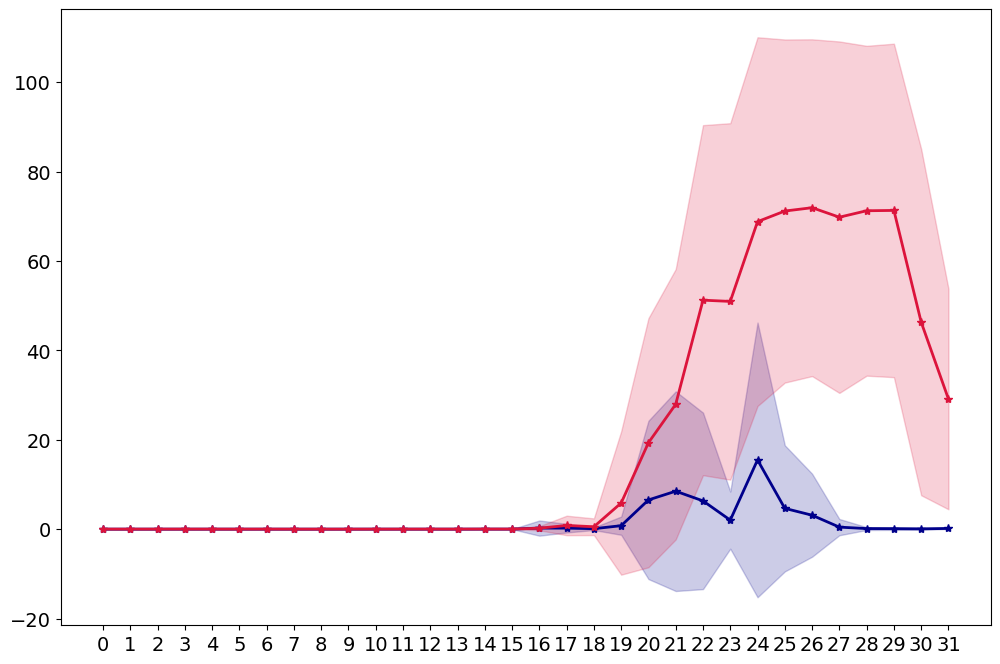

In [4]:
fig = plt.figure(figsize=(12,8))
plt.plot(range(len(x_list)), x_list, marker='*', label='X', color='#00008B',linewidth=2,) # , c=colors, cmap='viridis'
plt.plot(range(len(x_list)), y_list, marker='*', label='Y', color='#DC143C',linewidth=2,) # , c=colors, cmap='RdBu')
plt.fill_between(range(len(x_list)), [a - b for a, b in zip(x_list, x_var)], [a + b for a, b in zip(x_list, x_var)], color='#00008B', alpha=0.2)
plt.fill_between(range(len(x_list)), [a - b for a, b in zip(y_list, y_var)], [a + b for a, b in zip(y_list, y_var)], color='#DC143C', alpha=0.2)
plt
# plt.legend()
plt.xticks(range(model.cfg.n_layers), fontsize=14)
plt.yticks(fontsize=14)
# fig.savefig('probability-dynamics-llama-chat-0.pdf')
plt.show()

## The head takes in country and output city through OV circuit 

In [17]:
from easy_transformer.fact_dataset_llama import (
    FactDataset,
)
f_dataset = FactDataset(
    prompt_type="NCNC",
    N=1000,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)
f_dataset = f_dataset#.add_a_shot()#.add_a_shot()#.add_a_shot()

def func(dataset):
    cache = {}
    
    for layer in [24]:
        model.cache_some(cache, lambda x: x == f"blocks.{layer}.hook_resid_pre", device='cuda:3') 
        model(dataset.toks.long())
        model.blocks[layer].ln1.to('cuda:1')
        z_0 = model.blocks[layer].ln1(cache[f"blocks.{layer}.hook_resid_pre"].to('cuda:1'))#.to('cuda:1')
        # [batch pos d_model]
        # for head in range(model.cfg.n_heads):
        
        head = 14
        
        w_v = model.blocks[layer].attn.v_proj.weight.to('cuda:1').reshape(model.cfg.n_heads, model.cfg.d_head, -1).transpose(1,2)[head]
        # [d_model, d_head]

        v = torch.einsum("eab,bc->eac", z_0, w_v)
        # v += model.blocks[layer].attn.b_V[head].unsqueeze(0).unsqueeze(0)
        w_o = model.blocks[layer].attn.out_proj.weight.to('cuda:1').reshape(model.cfg.d_model, -1, model.cfg.d_head).transpose(0, 1)[head]
        # [d_model, d_head]
        o = torch.einsum("sph,dh->spd", v, w_o)
        model.ln_final.to('cuda:0')
        model.unembed.to('cuda:0')
        logits = model.unembed(model.ln_final(o.to('cuda:0')))

        k = 10
        for seq_idx, prompt in enumerate(dataset.ioi_prompts[:20]):
            pred_tokens = [
                    model.tokenizer.decode(token)
                    for token in torch.topk(
                        logits[seq_idx, dataset.word_idx['N'][seq_idx]], k
                    ).indices
                ]
            # print(prompt)
            print(pred_tokens)

        ic_probs = 0
        in_probs = 0
        iw_probs = 0

        for seq_idx, prompt in enumerate(dataset.ioi_prompts):
            probs = logits[seq_idx, dataset.word_idx['N'][seq_idx]]
            in_probs += probs[dataset.N_tokenIDs[seq_idx]]
            iw_probs += probs[dataset.IW_tokenIDs[seq_idx]]

        print(f'layer {layer} head {head} ov')
        print(in_probs / dataset.N)
        print(iw_probs / dataset.N)

print(f_dataset.ioi_prompts[:2])
func(f_dataset)

model.reset_hooks()

[{'text': "To emphasize, Thailand's capital is Bangkok", 'N': 'Thailand', 'C': 'Bangkok', 'R': 'capital', 'TEMPLATE_IDX': 14, 'IW answer': 'Bangkok'}, {'text': "We confirm that France's capital is Paris", 'N': 'France', 'C': 'Paris', 'R': 'capital', 'TEMPLATE_IDX': 4, 'IW answer': 'Paris'}]
['Bang', 'Vietnam', 'Georgia', 'Nep', 'Georg', 'Malays', 'Sri', 'Atlanta', 'Ath', 'Greece']
['France', 'French', 'France', 'Frankreich', 'rench', 'француз', 'Francia', 'Paris', 'францу', 'französischen']
['Vietnam', 'Bang', 'Malays', 'Niger', 'Nep', 'Eth', 'Greek', 'Greece', 'Camb', 'Mexico']
['France', 'French', 'France', 'rench', 'Frankreich', 'француз', 'Francia', 'францу', 'Paris', 'französischen']
['Spain', 'Spanish', 'Span', 'Span', 'span', 'span', 'España', 'Madrid', 'Espagne', 'españ']
['Portugal', 'Portuguese', 'portug', 'Portug', 'Lis', 'Port', 'Port', 'Porto', 'Пор', 'пор']
['Egypt', 'gypt', 'egy', 'egy', 'Egy', 'Cleveland', 'airo', 'Ohio', 'py', 'Py']
['Spain', 'Spanish', 'Span', 'Span',

## linear regression

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from easy_transformer.fact_dataset_llama import (
    FactDataset,
)
def train(dataset, layer_idx, pos, i, k):

    div_size = dataset.N // k
    train_dataset = FactDataset(prompt_type="NCNC", tokenizer=model.tokenizer,prompts=dataset.ioi_prompts[:div_size * i] + dataset.ioi_prompts[div_size * (i+1):])
    test_dataset = None
    if k > 1:
        test_dataset = FactDataset(prompt_type="NCNC", tokenizer=model.tokenizer,  prompts=dataset.ioi_prompts[div_size * i : div_size * (i+1)])
    cache = {}

    model.cache_some(cache, lambda x: f"blocks.{layer_idx}" in x, device='cuda:3')
   
    model(train_dataset.toks.long())
    
    x = []

    y = cache[f'blocks.{layer_idx}.hook_mlp_out'][torch.arange(train_dataset.N), train_dataset.word_idx[pos]].detach().to('cuda:0')
    resid_pre = cache[f'blocks.{layer_idx}.hook_resid_pre'].to('cuda:0') 
    
    for head in range(model.cfg.n_heads):
        attn_out = cache[f'blocks.{layer_idx}.attn.hook_result'][:,:,head].to('cuda:0') # [225, seq, head_num, 4096]
        # print(attn_out.shape)
        tmp = attn_out[torch.arange(train_dataset.N), train_dataset.word_idx[pos]].detach()
        # print(tmp.shape) 
        x.append(tmp) 

    tmp = resid_pre[torch.arange(train_dataset.N), train_dataset.word_idx[pos]].detach() # [225 4096]
    
    x.append(tmp) #[]

    # x.append(model.blocks[layer_idx].attn.b_O.unsqueeze(0).repeat(train_dataset.N, 1).to('cuda:0')) #b_O is omitted in paper because this is a model-specific term.

    x = torch.stack(x, dim=0) # [33 225 4096] # 13, 100, 768

    # y = \sum hi + resid_pre + M(\sum hi) \approx \sum wi hi + wr resid_pre

    from torch.optim import SGD
    loss = torch.nn.MSELoss(reduction='mean')
    weight = torch.tensor(torch.ones(x.shape[0], 1, 1), device='cuda', requires_grad=True)
    bias = torch.tensor(torch.zeros(x.shape[-1]), device='cuda', requires_grad=True)

    optimizer = SGD([weight, bias], lr=5e-3, momentum=0.99)
    steps = 60000
    best_l = 999
    best_w = None
    best_b = None
    best_error = 0
    for i in tqdm(range(steps)):
        optimizer.zero_grad()
        l = loss((weight * x).sum(dim=0) + bias, y)
        l.backward()
        optimizer.step()
        if i % 100 == 0:
            if l < best_l:
                best_l = l
                best_w = weight.view(-1)
                best_error = torch.sqrt(best_l) / torch.norm(y, dim=-1).mean(0)
                best_b = bias
    print(f'layer {layer_idx}')
    print(best_l)
    print(best_w.view(-1))
    print(best_error)
    del cache, x

    tensor_save_dir = f'saved_tensors/nation_fact/{model.cfg.model_name}'
    os.makedirs(tensor_save_dir, exist_ok=True) 

    torch.save(best_b, f'{tensor_save_dir}/layer{layer_idx}-bias-pos{pos}.pt')

    if test_dataset:
        cache = {}
        model.cache_all(cache,device='cuda:3')
        model(test_dataset.toks.long())
        x = []
        y = cache[f'blocks.{layer_idx}.hook_mlp_out'][torch.arange(test_dataset.N), test_dataset.word_idx[pos]].detach()
        resid_pre = cache[f'blocks.{layer_idx}.hook_resid_pre']
        for head in range(model.cfg.n_heads):
            attn_out = cache[f'blocks.{layer_idx}.attn.hook_result'][:,:,head]
            x.append(attn_out[torch.arange(test_dataset.N), test_dataset.word_idx[pos]].detach())
        x.append(resid_pre[torch.arange(test_dataset.N), test_dataset.word_idx[pos]].detach())
        # x.append(model.blocks[layer_idx].attn.b_O.unsqueeze(0).repeat(test_dataset.N, 1))
        x = torch.stack(x, dim=0) # 13, 100, 4096
        print('test loss: ', loss((weight * x).sum(dim=0) + bias, y))
        del cache, x

f_dataset = FactDataset(
    prompt_type="NCNC",
    N=1000,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)

# for i in range(4): # 4-fold
#     train(f_dataset, layer_idx=11, pos='end', i=i, k=4)
for idx in [23]:
    train(f_dataset, layer_idx=idx, pos='end', i=1, k=1) # one-fold
    model.reset_hooks()


100%|██████████| 60000/60000 [00:33<00:00, 1785.89it/s]


layer 23
tensor(0.0474, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([ 0.9842,  0.6636,  0.5232,  0.0864, -0.0688,  0.7507, -0.1709,  0.9557,
         0.9131,  0.6968, -0.0151,  0.2713, -0.1202,  0.5458,  0.2360, -0.1036,
         0.1955,  0.0505, -0.0597,  0.0452,  0.1732,  0.6208,  0.1229,  0.5619,
         0.5980,  0.0535,  0.6315,  0.6369, -0.0177,  0.6642, -0.0439,  0.8610,
         0.0314], device='cuda:0', grad_fn=<ViewBackward0>)
tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)


## 用拟合的系数模拟mlp，对比模拟的mlp和原本mlp的差别

In [ ]:
pos = 'end'
end_weights = {'end': torch.tensor([
            [-0.3778, 0.9958, -0.2921, 0.2115, -0.5219, 1.4215, -0.3252, -0.2877,  0.3062, -0.0167, -0.1202, -0.4430, -0.0062, 1.3332],  # 0, 
            [-0.2421, -0.3286, -0.4107, -0.4428, -0.3211, -0.7429, -0.6300, -0.4886,  -0.4656, -0.7584, -0.3896, -0.4697, -0.1551, 0.3200], # 1 
            [-0.2933, -0.4398, -0.2285, -0.2141, -0.2279, -0.0900, -0.2096, -0.1632,  -0.2610, -0.2997, -0.2742, -0.2601, -0.0950, -0.2256],  # 2
            [-0.7560, -0.1242, -0.1355, 0.0232, -0.5973, -0.2991, -0.1133, -0.1518,  -0.1182, -0.3953, -0.0024, -0.2150, -0.0496, -0.5916], # 3
            [ 0.1806, -0.3129, -0.2375, -0.0230, -0.2580, -0.3304, -0.1971, -0.1036,  -0.4408, -0.2970, -0.1990, -0.0452, -0.0516, -0.7870],  # 4
            [-0.4658, 0.0244, -0.0608, -0.1969, -0.2394, -0.7087, -0.2687, -0.1716,  -0.0244, -0.2759, -0.1846, 0.0645, -0.1284, -0.3789], # 5
            [-0.3550, -0.3395, -0.1759, -0.2013, -0.2027, -0.2461, -0.1557, -0.2122,  -0.2105, -0.6289, -0.0471, -0.2553, -0.0870, -0.6657], # 6
            [ 0.2620, -0.2187, 0.7925, -0.0600, -0.1395, -0.1094, 0.0183, -0.2693,  0.0841, -0.1203, -0.1932, -1.4702, -0.0678, -0.3834],  # 7
            [ 0.0077, -0.9276, -0.0434, -0.0907, -0.0201, -0.0216, -0.3901, 0.1726,  0.0927, -0.1214, -0.1611, -0.1246, -0.0216, 0.8440], # 8
            [-0.0535, -0.2456, 0.0458, 0.0066, -0.2320, -0.1226, -0.1727, -0.0306,  0.0757, -0.0934, -0.0753, -0.6449, 0.0566, 1.3823], # 9
            [-7.4195e-02, 7.2448e-02, -8.9567e-02, 1.5036e-01, -1.0521e+00,  -1.6935e-01, -1.1128e-01, -9.3926e-02, -9.4067e-01, -4.8869e-01,  3.5116e-03, -3.3442e-01, 9.9636e-02, 7.2961e+00],
            [-0.2244, 0.7351, -0.1053, -0.3125, -0.0516, 1.5537, 0.5440, 0.4152,  0.1306, 0.9774, 0.1323, 0.2206, 0.0079, 2.5818], # 11
        ]).cuda(),
    }

f_dataset = FactDataset(
    prompt_type="NCNC",
    N=1000,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)

with torch.no_grad():
    embed = model.embed(f_dataset.toks.long())
    pos_embed = model.pos_embed(f_dataset.toks.long(), )
    residual = embed + pos_embed

    cache = {}
    model.cache_all(cache) 
    model(f_dataset.toks.long(),)

    from torch.optim import SGD
    loss = torch.nn.MSELoss(reduction='mean')

    device = 'cuda:0'
    for i in range(model.cfg.n_layers):
        if i > model.cfg.n_layers // 2:
            residual = residual.to('cuda:1')
            device = 'cuda:1'
        residual_pre = residual.clone()

        attn_out = model.blocks[i].attn(
                    residual,
                    no_reduce=True
                ) # B, L, n_head, dim
        
        residual_mid = residual_pre + attn_out.sum(-2) #+ model.blocks[i].attn.b_O

        terms = torch.concat([attn_out[torch.arange(f_dataset.N), f_dataset.word_idx[pos]].permute(1, 0, 2), 
                            residual_pre[torch.arange(f_dataset.N), f_dataset.word_idx[pos]].unsqueeze(0)
                            ], dim=0) #model.blocks[i].attn.b_O.unsqueeze(0).repeat(f_dataset.N, 1).unsqueeze(0)
        
        bias = torch.load(f'{tensor_save_dir}/layer{i}-bias-pos{pos}.pt')

        terms = end_weights[pos][i][:, None, None].to(device) * terms

        mlp_out = model.blocks[i].mlp(
                    model.blocks[i].ln2(residual_mid),
                )

        # l = loss(mlp_out[torch.arange(f_dataset.N), f_dataset.word_idx[pos]], terms.permute(1, 0, 2).sum(1) + bias)
        # print(l) # assert lr is good 

        mlp_out[torch.arange(f_dataset.N), f_dataset.word_idx[pos]] = terms.permute(1, 0, 2).sum(1) + bias.to(device)
        
        residual = residual_mid + mlp_out

    residual = model.ln_final(residual)  # [batch, pos, d_vocab]
    logits_manual = model.unembed(residual.to('cuda:0'))  # [batch, pos, d_vocab]
    IW_logits_manual = logits_manual[
                torch.arange(len(f_dataset)),
                f_dataset.word_idx["end"],
                f_dataset.IW_tokenIDs,
            ]
    print(IW_logits_manual.mean())


    logits_ori = model(f_dataset.toks.long())
    IW_logits_ori = logits_ori[
                torch.arange(len(f_dataset)),
                f_dataset.word_idx["end"],
                f_dataset.IW_tokenIDs,
            ]
    print(IW_logits_ori.mean())

    import torch.nn.functional as F
    probs_ori = F.softmax(logits_ori, dim=-1)
    probs_manual = F.softmax(logits_manual, dim=-1)
    kl_div = F.kl_div(probs_ori.log(), probs_manual, reduction='batchmean')
    print(kl_div)
model.reset_hooks()

## to project intercept to hyperplane

In [4]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import torch.nn.functional as F
from fancy_einsum import einsum

layer_idx = 19

f_dataset = FactDataset(
    prompt_type="NCNC",
    N=1000,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)

cache = {}
with torch.no_grad():
    model.cache_some(cache, lambda x: str(layer_idx) in x, device='cuda:3')
    model(f_dataset.toks.long())

    print(f'layer {layer_idx}')
    model.ln_final.to("cuda:0")
    resid_mid = model.ln_final(cache[f'blocks.{layer_idx}.hook_resid_mid'].to("cuda:0"))[torch.arange(f_dataset.N), f_dataset.word_idx['end']].detach().cpu()
    model.ln_final.to("cuda:2")
    mlp_out = model.ln_final(cache[f'blocks.{layer_idx}.hook_mlp_out'].to("cuda:2"))[torch.arange(f_dataset.N), f_dataset.word_idx['end']].detach().cpu()
    model.ln_final.to("cuda:3")
    resid_post = model.ln_final(cache[f'blocks.{layer_idx}.hook_resid_post'].to("cuda:3"))[torch.arange(f_dataset.N), f_dataset.word_idx['end']].detach().cpu()
    print(resid_post.shape)
    logit_n = model.unembed.output_projection.weight[f_dataset.N_tokenIDs].detach().cpu() #.unsqueeze(0).repeat(f_dataset.N, 1, 1)
    
    logit_iw = model.unembed.output_projection.weight[f_dataset.IW_tokenIDs].detach().cpu() #.unsqueeze(0).repeat(f_dataset.N, 1, 1)
    print(logit_n.shape)
    bias = torch.load(f'{tensor_save_dir}/layer{layer_idx}-bias-posend.pt').cpu()
    print(bias.shape)
    print('post @ iw: ', einsum('b d, b d -> b', resid_post, logit_iw).mean(0))
    print('post @ n: ', einsum('b d, b d -> b', resid_post, logit_n).mean(0))
    print('post <-> iw: ', F.cosine_similarity(resid_post, logit_iw, dim=-1).mean(0))
    print('post <-> n: ', F.cosine_similarity(resid_post, logit_n, dim=-1).mean(0))

    print('mid <-> iw: ', F.cosine_similarity(resid_mid, logit_iw, dim=-1).mean(0))
    print('mid <-> n: ', F.cosine_similarity(resid_mid, logit_n, dim=-1).mean(0))
    
    print('mlp <-> iw: ', F.cosine_similarity(mlp_out, logit_iw, dim=-1).mean(0))
    print('mlp <-> n: ', F.cosine_similarity(mlp_out, logit_n, dim=-1).mean(0))
   
    sim = 0
    for i in range(f_dataset.N):
        M = torch.column_stack((logit_iw[i], logit_n[i]))
        # print(torch.linalg.matrix_rank(M)) # rank must be 2
        P = M @ torch.linalg.inv(M.T @ M) @ M.T
        A_proj = P @ bias
        sim += F.cosine_similarity(A_proj,  logit_iw[i] - logit_n[i], dim=0)  # - logit_n[i]

    print(sim / f_dataset.N)

model.reset_hooks()

layer 19
torch.Size([225, 4096])
torch.Size([225, 4096])
torch.Size([4096])
post @ iw:  tensor(9.6011)
post @ n:  tensor(7.8805)
post <-> iw:  tensor(0.0892)
post <-> n:  tensor(0.0789)
mid <-> iw:  tensor(0.0840)
mid <-> n:  tensor(0.0884)
mlp <-> iw:  tensor(0.0308)
mlp <-> n:  tensor(-0.0120)
tensor(0.8156)


## To examine b^{11}  llama can't calculate

In [6]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import torch.nn.functional as F
from fancy_einsum import einsum
import matplotlib.pyplot as plt

N = 1000
f_dataset = FactDataset(
    prompt_type="NCNC",
    N=N,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)

layer_idx = 31

dataset = f_dataset #.add_a_shot().add_a_shot()
import torch
from collections import Counter
freq_counter = torch.load("openwebtext_gpt2_freq_counter")
logit_mean = torch.zeros(model.cfg.d_model).to('cuda:0')

cache = {}
model.cache_some(cache, lambda x: f'blocks.{layer_idx}' in x,device='cuda:2')
with torch.no_grad():
    model(dataset.toks.long())
    model.reset_hooks()
resid_post = cache[f'blocks.{layer_idx}.hook_resid_post'][torch.arange(dataset.N), dataset.word_idx['end']]
resid_mid = cache[f'blocks.{layer_idx}.hook_resid_mid'][torch.arange(dataset.N), dataset.word_idx['end']]
mlp_out = cache[f'blocks.{layer_idx}.hook_mlp_out'][torch.arange(dataset.N), dataset.word_idx['end']]
bias = torch.load(f'{tensor_save_dir}/layer{layer_idx}-bias-posend.pt').to('cuda:0')

logit_iw = model.unembed.output_projection.weight[dataset.IW_tokenIDs].unsqueeze(0) #.permute(1, 0)
logit_n = model.unembed.output_projection.weight[dataset.N_tokenIDs].unsqueeze(0)



from tqdm import  tqdm
alpha = 0
for tok in tqdm(freq_counter.items()):
    alpha += tok[1] / 30000000
    logit_mean += (model.unembed.output_projection.weight.T[:, tok[0]] * tok[1]).to('cuda:0') / 30000000
logit_mean /= alpha


sim1 = 0
sim2 = 0

for i in range(dataset.N):
    
    M = torch.column_stack((logit_iw, logit_mean))
    
    P = M @ torch.linalg.inv(M.T @ M) @ M.T
    sim1 += F.cosine_similarity(P @ bias, logit_mean, dim=0)
    sim2 += F.cosine_similarity(P @ bias, logit_mean - logit_iw, dim=0)

print(sim1 / dataset.N)
print(sim2 / dataset.N)

model.reset_hooks()

  0%|          | 76/50154 [00:00<00:55, 896.61it/s]


IndexError: index 44697 is out of bounds for dimension 1 with size 32000

In [ ]:
f_dataset = FactDataset(
    prompt_type="NCNC",
    N=1000,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)

print()

## mitigating the suppression by the final layer

In [3]:
import torch.nn.functional as F
import torch.nn as nn
from fancy_einsum import einsum
import matplotlib.pyplot as plt

f_dataset = FactDataset(
    prompt_type="NCNC",
    N=1000,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)
f_dataset = f_dataset#.add_a_shot()#.add_a_shot()
layer_idx = 31
layer_str = str(layer_idx)

x_list = []
y_list = []
x_var = []
y_var = []
cache = {}
model.cache_some(cache, lambda x : layer_str in x, device='cuda:3')
with torch.no_grad():
    model(f_dataset.toks.long())

gpu_num = torch.cuda.device_count()-1
device_id = int(layer_idx / model.cfg.n_layers * gpu_num)

input_shape = f_dataset.toks.shape[-1]
mask = torch.ones(input_shape, input_shape).to(f'cuda:{device_id}') # 0-shot mask
# # mask = torch.ones(21, 21).to(f'cuda:{device_id}') # 1-shot mask
# # mask = torch.ones(28, 28).to(f'cuda:{device_id}')  # 2-shot mask

mask = torch.tril(mask, diagonal=-1) * -99999

# apply attention mask

attn_scores = cache[f'blocks.{layer_idx}.attn.hook_attn_scores'].to(f'cuda:{device_id}') #+ mask[None, None, :, :]
attn_matrix =  nn.functional.softmax(
                attn_scores, dim=-1, dtype=torch.float32
            )
v = cache[f'blocks.{layer_idx}.attn.hook_v'].to(f'cuda:{device_id}').transpose(1, 2)
print(v.shape)
print(attn_scores.shape)
z = torch.matmul(attn_matrix, v)
z = z.transpose(1, 2).contiguous() #"batch pos head_index d_head


# z = z.reshape(bsz, q_len,  d_model)


# print(z)
# input()
# out = self.out_proj(z)
# print(out)
wo = model.blocks[layer_idx].attn.out_proj.weight.reshape(model.cfg.d_model, -1, model.cfg.d_head)
# print(z.shape)
out = torch.einsum(" ...ikj,...kj ->...ki",[wo, z])
result = out.detach()
out = out.sum(-2) # [bsz, q_len, d_model]
# z = einsum(
#             "batch key_pos head_index d_head, \
#             batch head_index query_pos key_pos -> \
#             batch query_pos head_index d_head",
#             cache[f'blocks.{layer_idx}.attn.hook_v'].to(f'cuda:{device_id}'),
#             attn_matrix,
#         )
# result = einsum(
#                 "batch pos head_index d_head, \
#                     head_index d_head d_model -> \
#                     batch pos head_index d_model",
#                 z,
#                 model.blocks[layer_idx].attn.W_O.to(f'cuda:{device_id}'),
#         )
# out = einops.reduce(
#                     result, "batch position index model->batch position model", "sum"
#                 ) + model.blocks[layer_idx].attn.b_O.to(f'cuda:{device_id}')
resid_pre = cache[f'blocks.{layer_idx}.hook_resid_pre'].to(f'cuda:{device_id}')
resid_mid = resid_pre + out


normalized_resid_mid = model.blocks[layer_idx].ln2(resid_mid)

mlp_out = model.blocks[layer_idx].mlp(normalized_resid_mid)

print('mask_attn done...')


torch.Size([225, 32, 19, 128])
torch.Size([225, 32, 19, 19])
mask_attn done...


In [4]:

"""
train a new bias because attention outputs has changed
"""
# layer_idx = 11
pos = 'end'
x = []
y = mlp_out[torch.arange(f_dataset.N), f_dataset.word_idx[pos]].detach().to('cuda:0')
for head in range(model.cfg.n_heads):
    attn_out = result[:,:,head]  
    x.append(attn_out[torch.arange(f_dataset.N), f_dataset.word_idx[pos]].detach().to('cuda:0'))
x.append(resid_pre[torch.arange(f_dataset.N), f_dataset.word_idx[pos]].detach().to('cuda:0'))
# x.append(model.blocks[layer_idx].attn.b_O.unsqueeze(0).repeat(f_dataset.N, 1).to('cuda:0'))
x = torch.stack(x, dim=0) # head+1, N, 4096
from torch.optim import SGD
loss = torch.nn.MSELoss(reduction='mean')
weight = torch.tensor(torch.ones(x.shape[0], 1, 1), device='cuda:0', requires_grad=True)
bias = torch.tensor(torch.zeros(x.shape[-1]), device='cuda:0', requires_grad=True)
optimizer = SGD([weight, bias], lr=5e-3, momentum=0.99)
print('start training...')
steps = 60000
best_l = 999
best_w = None
best_b = None
best_error = 0
for i in tqdm(range(steps)):
    optimizer.zero_grad()
    l = loss((weight * x).sum(dim=0) + bias, y)
    l.backward()
    optimizer.step()
    if i % 100 == 0:
        if l < best_l:
            best_l = l
            best_w = weight.view(-1)
            best_error = torch.sqrt(best_l) / torch.norm(y, dim=-1).mean(0)
            best_b = bias

model.reset_hooks()


start training...


100%|██████████| 60000/60000 [00:33<00:00, 1777.09it/s]


['Lis', 'not', 'L', 'a', 'the', 'in', '"', 'indeed', '', 'also', ',', 'actually', '\n', 'called', 'one', "'", 'located', ':', 'L', 'NOT']
tensor(1.5948, device='cuda:1', grad_fn=<DivBackward0>)
['Lis', 'not', 'the', 'located', 'a', 'in', 'also', ',', 'actually', 'L', 'situated', 'Porto', 'indeed', '"', 'called', 'Portugal', 'one', ':', 'home', 'simply']
tensor(3.5069, device='cuda:1', grad_fn=<DivBackward0>)
[tensor(0.0004), tensor(0.0016)]
[tensor(0.5243), tensor(0.2911)]


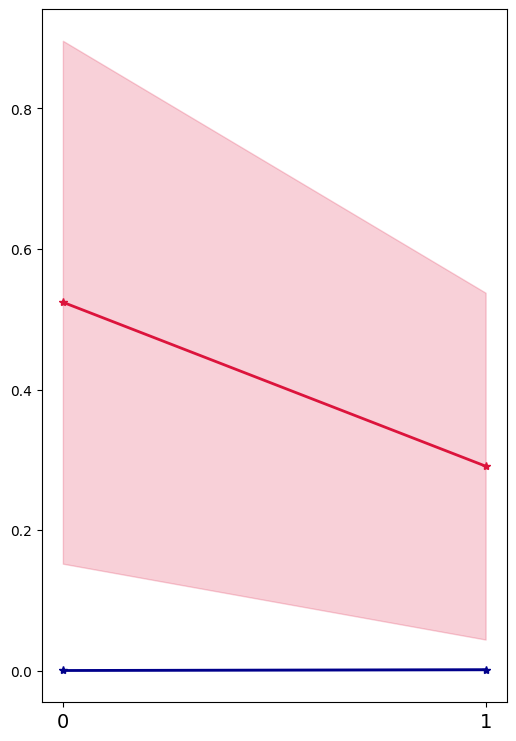

In [7]:

# subtract intercept
x_list = []
y_list = []
resid_post = resid_mid + mlp_out #- best_b.to(f'cuda:{device_id}')
# resid_pre, 
for idx, o in enumerate([resid_mid,  resid_post]):
    logits = model.unembed(model.ln_final(o.to('cuda:1')))
    k = 20
    seq_idx = 0
    pred_tokens = [
            model.tokenizer.decode(token)
            for token in torch.topk(
                logits[seq_idx, f_dataset.word_idx['end'][seq_idx]], k
            ).indices
        ]

    print(pred_tokens)

    x_probs = []
    y_probs = []
    ent = 0
    for seq_idx, prompt in enumerate(f_dataset.ioi_prompts):
        probs = torch.softmax(logits[seq_idx, f_dataset.word_idx['end'][seq_idx]], dim=0)
        ent += -(probs * torch.log(probs)).sum()
        x_probs.append(probs[f_dataset.N_tokenIDs[seq_idx]].detach().cpu())
        y_probs.append(probs[f_dataset.IW_tokenIDs[seq_idx]].detach().cpu())
    
    x_list.append(torch.mean(torch.tensor(x_probs)))
    y_list.append(torch.mean(torch.tensor(y_probs)))
    x_var.append(torch.std(torch.tensor(x_probs)))
    y_var.append(torch.std(torch.tensor(y_probs)))
    print(ent / f_dataset.N)
print(x_list)
print(y_list)
model.reset_hooks()


fig = plt.figure(figsize=(6,9))
plt.plot(range(len(x_list)), x_list, marker='*', label='X', color='#00008B',linewidth=2,) # , c=colors, cmap='viridis'
plt.plot(range(len(x_list)), y_list, marker='*', label='Y', color='#DC143C',linewidth=2,) # , c=colors, cmap='RdBu')
plt.fill_between(range(len(x_list)), [a - b for a, b in zip(x_list, x_var)], [a + b for a, b in zip(x_list, x_var)], color='#00008B', alpha=0.2)
plt.fill_between(range(len(x_list)), [a - b for a, b in zip(y_list, y_var)], [a + b for a, b in zip(y_list, y_var)], color='#DC143C', alpha=0.2)

# plt.legend()
plt.xticks(range(0,2,1), fontsize=14)
# fig.savefig('last_layer-llama-0-no-mask.pdf')
plt.show()

['Lis', 'not', 'L', 'a', 'the', 'in', '"', 'indeed', '', 'also', ',', 'actually', '\n', 'called', 'one', "'", 'located', ':', 'L', 'NOT']
tensor(1.5948, device='cuda:1', grad_fn=<DivBackward0>)
['Lis', 'not', 'the', 'located', 'a', 'in', 'also', ',', 'actually', 'L', 'situated', 'Porto', 'indeed', '"', 'called', 'Portugal', 'one', ':', 'home', 'simply']
tensor(3.5069, device='cuda:1', grad_fn=<DivBackward0>)
[tensor(0.0004), tensor(0.0016)]
[tensor(0.5243), tensor(0.2911)]


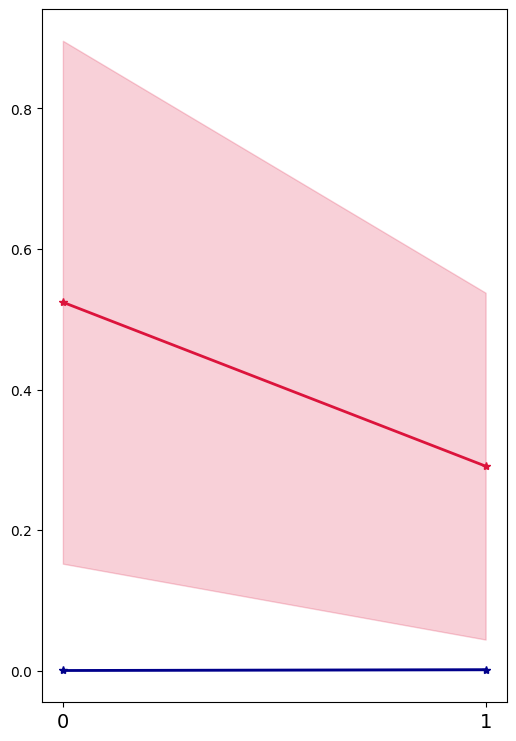

In [ ]:

# subtract intercept
x_list = []
y_list = []
resid_post = resid_mid + mlp_out #- best_b.to(f'cuda:{device_id}')
# resid_pre, 
for idx, o in enumerate([resid_mid,  resid_post]):
    logits = model.unembed(model.ln_final(o.to('cuda:1')))
    k = 20
    seq_idx = 0
    pred_tokens = [
            model.tokenizer.decode(token)
            for token in torch.topk(
                logits[seq_idx, f_dataset.word_idx['end'][seq_idx]], k
            ).indices
        ]

    print(pred_tokens)

    x_probs = []
    y_probs = []
    ent = 0
    for seq_idx, prompt in enumerate(f_dataset.ioi_prompts):
        probs = torch.softmax(logits[seq_idx, f_dataset.word_idx['end'][seq_idx]], dim=0)
        ent += -(probs * torch.log(probs)).sum()
        x_probs.append(probs[f_dataset.N_tokenIDs[seq_idx]].detach().cpu())
        y_probs.append(probs[f_dataset.IW_tokenIDs[seq_idx]].detach().cpu())
    
    x_list.append(torch.mean(torch.tensor(x_probs)))
    y_list.append(torch.mean(torch.tensor(y_probs)))
    x_var.append(torch.std(torch.tensor(x_probs)))
    y_var.append(torch.std(torch.tensor(y_probs)))
    print(ent / f_dataset.N)
print(x_list)
print(y_list)
model.reset_hooks()


fig = plt.figure(figsize=(6,9))
plt.plot(range(len(x_list)), x_list, marker='*', label='X', color='#00008B',linewidth=2,) # , c=colors, cmap='viridis'
plt.plot(range(len(x_list)), y_list, marker='*', label='Y', color='#DC143C',linewidth=2,) # , c=colors, cmap='RdBu')
plt.fill_between(range(len(x_list)), [a - b for a, b in zip(x_list, x_var)], [a + b for a, b in zip(x_list, x_var)], color='#00008B', alpha=0.2)
plt.fill_between(range(len(x_list)), [a - b for a, b in zip(y_list, y_var)], [a + b for a, b in zip(y_list, y_var)], color='#DC143C', alpha=0.2)

# plt.legend()
plt.xticks(range(0,2,1), fontsize=14)
# fig.savefig('last_layer-llama-0-no-mask.pdf')
plt.show()

## capital to name

In [ ]:
# 模型在ioi数据上正常的输出
model.reset_hooks()
model_logit_diff, _ = logit_diff(model, f_dataset, metric='n') # 返回两个token被预测logit的差
# model_io_probs = probs(model, f_dataset, type="IW") # 返回io token被预测的概率
print(
    f"The model gets average logit difference {model_logit_diff.item()}"
)
model_logit_diff, _ = logit_diff(model, f_dataset, metric='iw') # 返回两个token被预测logit的差
print(
    f"The model gets average logit difference {model_logit_diff.item()}"
)


name_dataset = (f_dataset.gen_flipped_prompts(('R', 'name')))
mean_dataset = (
        f_dataset.gen_flipped_prompts(("N", "RAND"))
    )
print(name_dataset.tokenized_prompts[:2])
print(name_dataset.word_idx['end'][:2])
# The circuit
circuit = {'todo': [(7,8)]}

# we then add hooks to the model to knockout all the heads except the circuit
model.reset_hooks()
model, _ = do_circuit_extraction(
    model=model,
    # get_heads_circuit返回字典，整个circuit中的head为key，格式为{(l,h):[x,x,x,x]}，value list的长度是数据集长度，值是每个样本当前head需要注意的token的index
    heads_to_remove=get_heads_circuit(ioi_dataset=f_dataset, circuit=circuit, pos=['end']),
    mlps_to_remove={},
    ioi_dataset=f_dataset,
    mean_dataset=name_dataset, # mean ablation
)

circuit_logit_diff, _ = logit_diff(model, f_dataset, metric='n')
print(
    f"The circuit gets average logit difference {circuit_logit_diff.item()}"
)
circuit_logit_diff, _ = logit_diff(model, f_dataset, metric='iw')
print(
    f"The circuit gets average logit difference {circuit_logit_diff.item()}"
)
# circuit_io_probs = probs(model, ioi_dataset, type="io") # 返回io token被预测的概率
# print(f"The circuit gets average IO probs {circuit_io_probs.item()} over {N} examples")

# print(f'Circuit acheves {100 - abs(circuit_logit_diff - model_logit_diff) / model_logit_diff * 100}% model performance') 
model.reset_hooks()

# Other Tools

## Visualize attention patterns

In [ ]:
pattern_d = FactDataset(
    prompt_type="NCNC",
    N=300,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    counterfact=False,
)
# pattern_d = pattern_d.add_a_shot().add_a_shot()
for head in range(model.cfg.n_heads):
    show_attention_patterns(model, [(11, head)], pattern_d[4:5], mode="attn", figure_save_dir=figure_save_dir)
model.reset_hooks()

## Copy Score

In [ ]:
def check_copy_circuit(model, layer, head, ioi_dataset, verbose=False, neg=False):
    cache = {}
    model.cache_some(cache, lambda x: x == f"blocks.{layer}.hook_resid_post")
    model(ioi_dataset.toks.long())
    if neg:
        sign = -1
    else:
        sign = 1

    gpu_num = torch.cuda.device_count()
    device_id = int(layer / model.cfg.n_layers * gpu_num)
    z_0 = cache[f"blocks.{layer}.hook_resid_post"].to(f'cuda:{device_id}')

    v = torch.einsum("eab,bc->eac", z_0, model.blocks[layer].attn.W_V[head])
    v += model.blocks[layer].attn.b_V[head].unsqueeze(0).unsqueeze(0)

    o = sign * torch.einsum("sph,hd->spd", v, model.blocks[layer].attn.W_O[head])
    logits = model.unembed(model.ln_final(o).to('cuda:0'))

    k = 10
    n_right = 0

    for seq_idx, prompt in enumerate(ioi_dataset.ioi_prompts):
        for word in ["N"]:
            pred_tokens = [
                model.tokenizer.decode(token)
                for token in torch.topk(
                    logits[seq_idx, ioi_dataset.word_idx[word][seq_idx]], k
                ).indices
            ]

            if "N" in word:
                name = "N"
            else:
                name = word
            if " " + prompt[name] in pred_tokens:
                n_right += 1
 
    percent_right = (n_right / (ioi_dataset.N)) * 100
    print(
        f"Copy circuit for head {layer}.{head} (sign={sign}) : Top {k} accuracy: {percent_right}%"
    )
    return percent_right


neg_sign = False
print(" --- Mover heads --- ")
check_copy_circuit(model, 7, 8, f_dataset, neg=neg_sign)
check_copy_circuit(model, 9, 8, f_dataset, neg=neg_sign)
check_copy_circuit(model, 10, 0, f_dataset, neg=neg_sign)
check_copy_circuit(model, 11, 3, f_dataset, neg=neg_sign)
check_copy_circuit(model, 11, 2, f_dataset, neg=neg_sign)

neg_sign = True
print(" --- Negative heads --- ")
check_copy_circuit(model, 10, 7, f_dataset, neg=neg_sign)
check_copy_circuit(model, 11, 10, f_dataset, neg=neg_sign)